* How likely am I to subscribe a term deposit?

* Experimenting of variables selection techniques.

* Explorations of the variables so serves as a good example of Exploratory Data Analysis and how that can guide the model creation and selection process.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
df = pd.read_csv('banking.csv')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


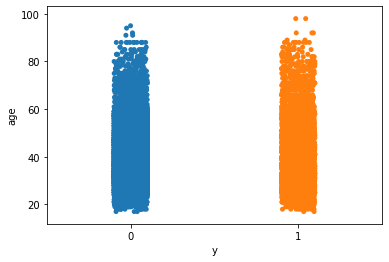

In [5]:
sns.stripplot(x="y", y="age", data=df, jitter=True)
plt.show();

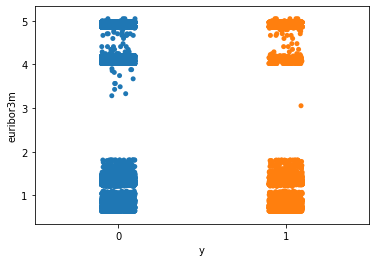

In [6]:
sns.stripplot(x="y", y="euribor3m", data=df, jitter=True)
plt.show();

In [7]:
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [8]:
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [9]:
df.poutcome.unique()

array(['nonexistent', 'success', 'failure'], dtype=object)

In [7]:
def replace_education(education):
    """
    This function codes the highest education attained.
    """
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    """
    This function codes the highest job earned.
    """
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2

df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))

In [8]:
look_up = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7,
            'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}

df['month'] = df['month'].apply(lambda x: look_up[x])

In [9]:
look_up = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}

df['day_of_week'] = df['day_of_week'].apply(lambda x: look_up[x])

In [10]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,6,4,3,2,1,0,1,8,4,210,1,999,0,2,1.4,93.444,-36.1,4.963,5228.1,0
1,53,9,4,2,0,0,0,1,11,5,138,1,999,0,2,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,12,3,8,0,1,0,1,6,4,339,3,6,2,1,-1.7,94.055,-39.8,0.729,4991.6,1


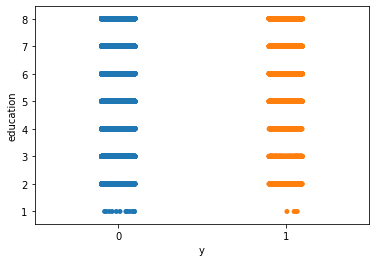

In [11]:
sns.stripplot(x="y", y="education", data=df, jitter=True)
plt.show();

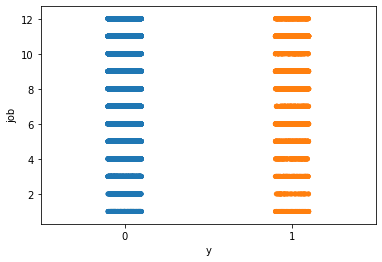

In [12]:
sns.stripplot(x="y", y="job", data=df, jitter=True)
plt.show();

In [13]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,6,4,3,2,1,0,1,8,4,210,1,999,0,2,1.4,93.444,-36.1,4.963,5228.1,0
1,53,9,4,2,0,0,0,1,11,5,138,1,999,0,2,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,12,3,8,0,1,0,1,6,4,339,3,6,2,1,-1.7,94.055,-39.8,0.729,4991.6,1


In [14]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
data.corr()['outcome'].sort_values(ascending=False)

outcome        1.000000
duration       0.405274
previous       0.230181
month          0.037187
education      0.035848
age            0.030399
day_of_week    0.010051
housing        0.009552
loan          -0.005038
job           -0.023020
marital       -0.026302
campaign      -0.066357
default       -0.099324
poutcome      -0.122089
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64

## Logistic Regression with one independent variable

We are going to begin with the simplest possible logistic model, using just one independent variable or feature, the duration.

In [15]:
y_simple = data['outcome']
x_n = 'duration' 
x_0 = data[x_n].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:40<00:00, 66.44draws/s] 


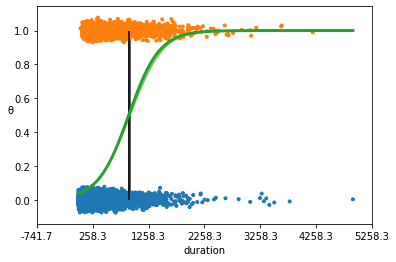

In [27]:
theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
az.plot_hpd(x_c, trace_simple['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

The above plot shows non subscription versus subscription (y = 0, y = 1). The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription, given that we know that the last time contact duration(the value of the duration).The boundary decision is represented as a (black) vertical line. According to the boundary decision, the  values of duration to the left correspond to y = 0 (non subscription), and the values to the right to y = 1 (subscription).

In [28]:
az.summary(trace_simple, var_names=['α', 'β'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-2.349,0.019,-2.382,-2.312,0.0,0.0,1461.0,1461.0,1464.0,1317.0,1.0
β,0.004,0.000,0.004,0.004,0.0,0.0,1597.0,1596.0,1590.0,1509.0,1.0


In [29]:
ppc = pm.sample_ppc(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

100%|██████████| 500/500 [00:02<00:00, 240.47it/s]


In [30]:
print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

Accuracy of the simplest model: 0.8933670000971157
f1 score of the simplest model: 0.2591093117408907


In [17]:
outcome.value_counts()

0    36548
1     4640
Name: y, dtype: int64

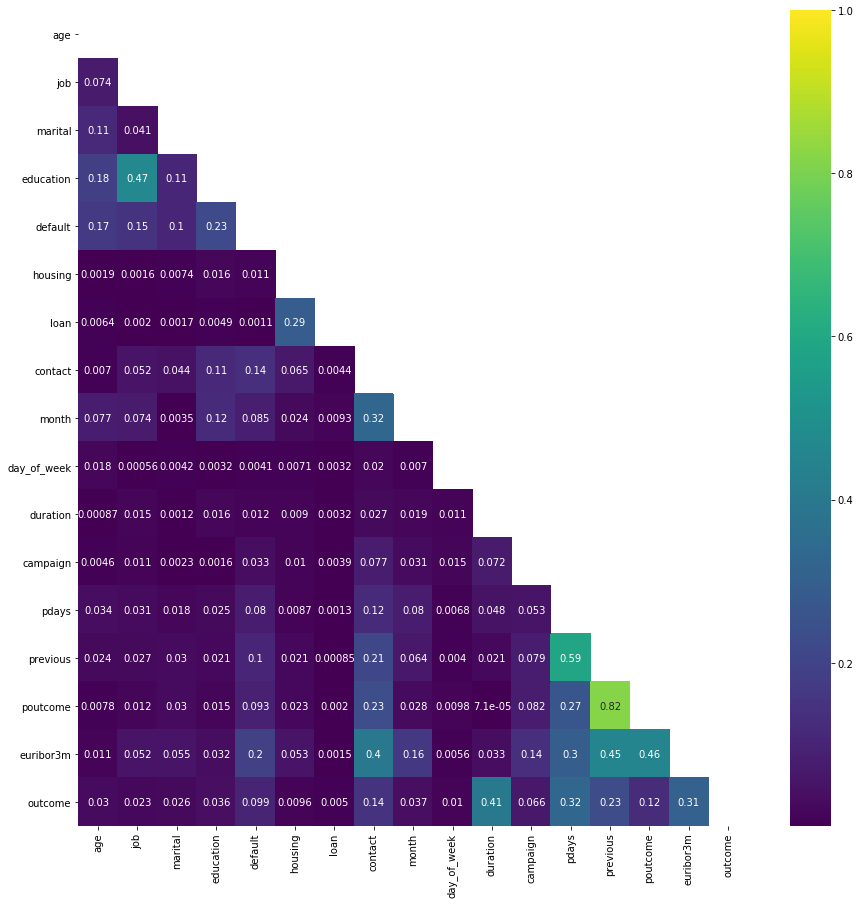

In [32]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

poutcome & previous have a high correlation, we can simply remove one of them, I decide to remove poutcome.

There are not many strong correlations with the outcome variable. The highest positive correlation is 0.41.

## Define logistic regression model using PyMC3 GLM method with 17 independent variables

We assume that the probability of a subscription outcome is a function of age, job, marital, education, default, housing, loan, contact, month, day of week, duration, campaign, pdays, previous and euribor3m. We need to specify a prior and a likelihood in order to draw samples from the posterior.

logit = β0 + β1(age) + β2(age)2 + β3(job) + β4(marital) + β5(education) + β6(default) + β7(housing) + β8(loan) + β9(contact) + β10(month) + β11(day_of_week) + β12(duration) + β13(campaign) + β14(campaign) + β15(pdays) + β16(previous) + β17(poutcome) + β18(euribor3m)  and y = 1 if outcome is yes and y = 0 otherwise.

With the math out of the way we can get back to the data. PyMC3 has a module - glm - for defining models using a patsy-style formula syntax. This seems really useful, especially for defining models in fewer lines of code. I use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, in which parameteres are tuned automatically.

Then we plot the trace infromation from the first 1000 parameters.

The idea of adding a age2 is completely borrowed from this tutorial, and I wanted to compare models laterly as well!

In [18]:
# Scale age by 10, it helps with model convergence.
data['age'] = data['age'] / 10
data['age2'] = np.square(data['age'])

## Define model using PyMC3 GLM method

PyMC3 has a module - glm - for defining models using a patsy-style formula syntax. This seems really useful, especially for defining models in fewer lines of code.

In [20]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age2, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [26:25<00:00,  3.53draws/s] 
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


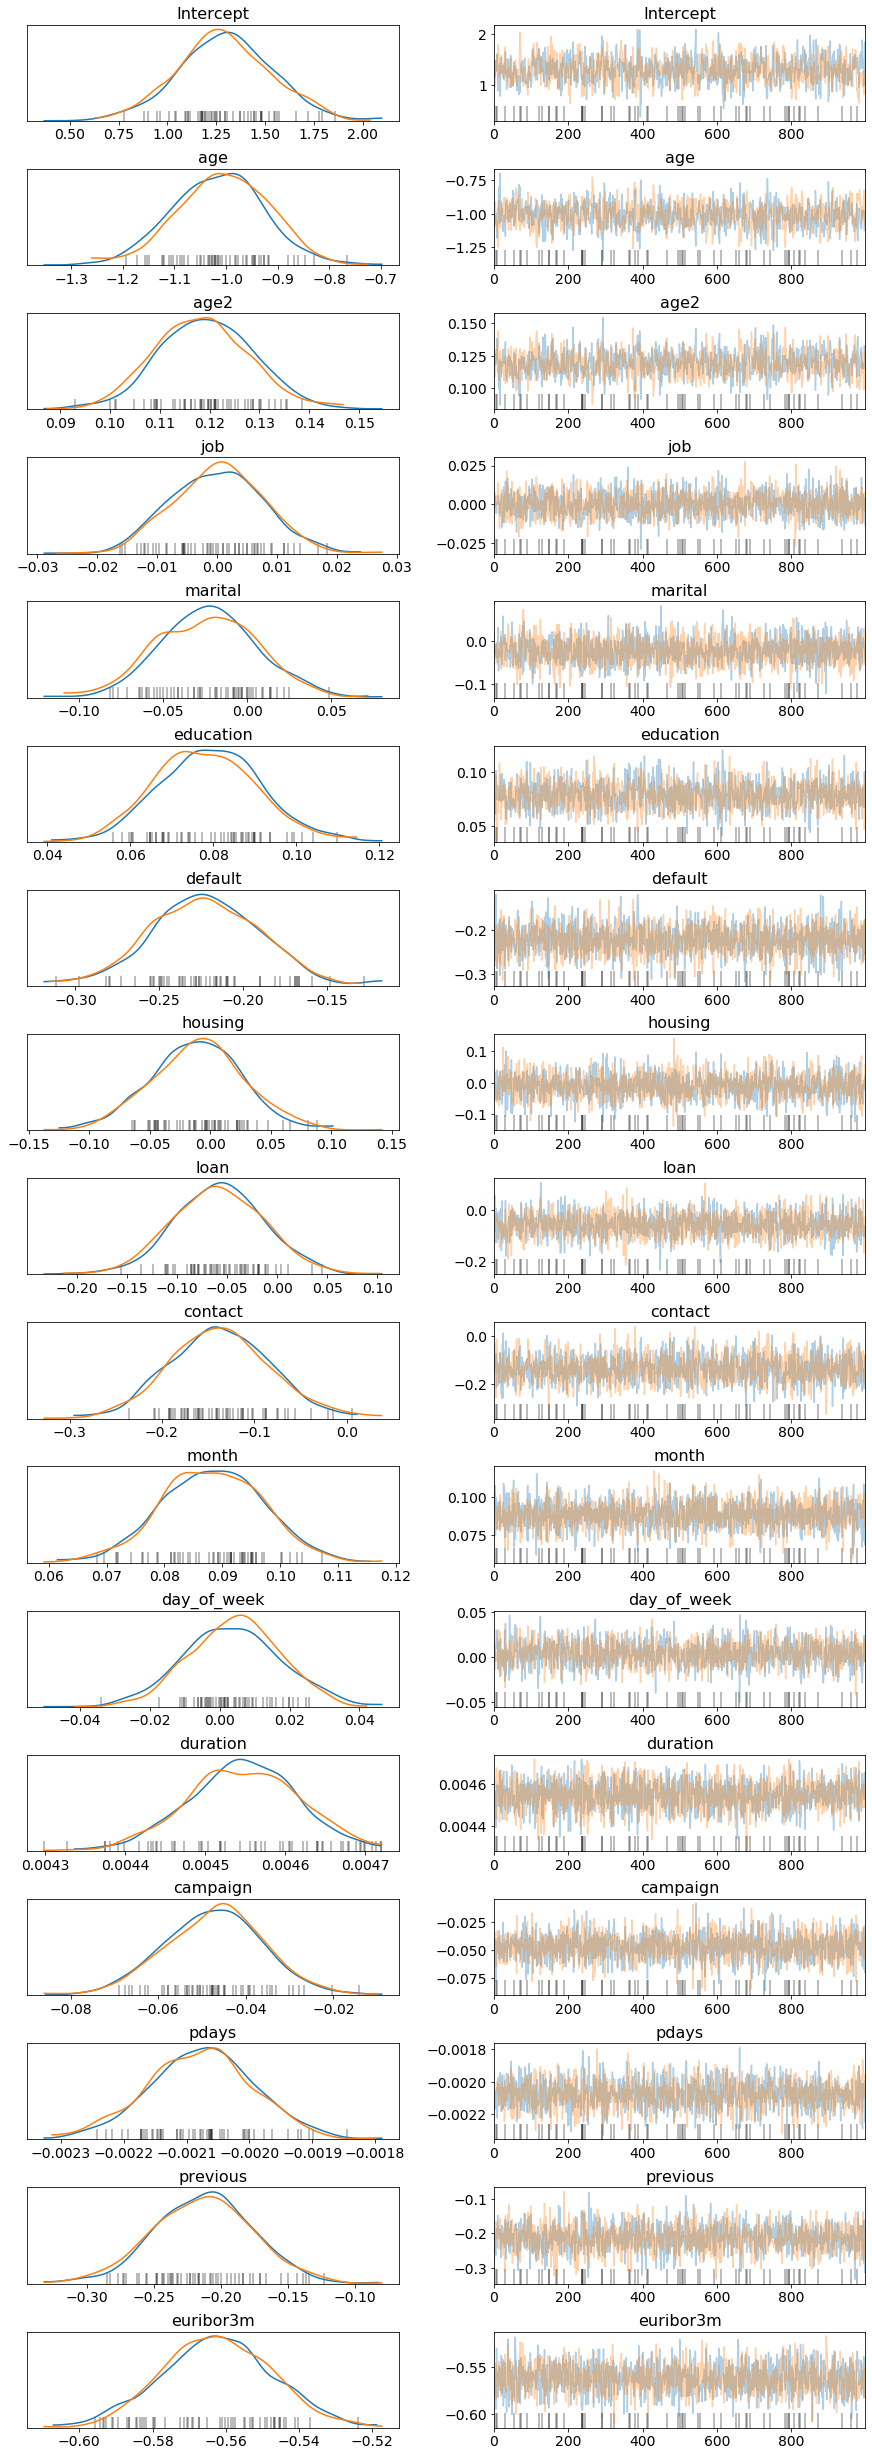

In [21]:
az.plot_trace(trace);

Each curve shows how the probability of subscribing a term deposit changes with age, given this customer is married.

The red curve represents university degree, the green curve represents and basic.9y education, the blue curve represents illiterate. For all three education levels, the probability of subscribing a term deposit decreases with age until approximately age 40, when the probability begins to increase. Notice that every curve is blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. 

In [31]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 1., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 5., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 8., 4.)

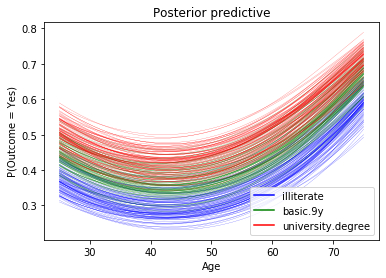

In [32]:
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(['lm'], [], color='b', label='illiterate')
green_line = mlines.Line2D(['lm2'], [], color='g', label='basic.9y') 
red_line = mlines.Line2D(['lm3'], [], color='r', label='university.degree')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Outcome = Yes)")
plt.xlabel("Age")
plt.show();

## Estimate Odds Ratio

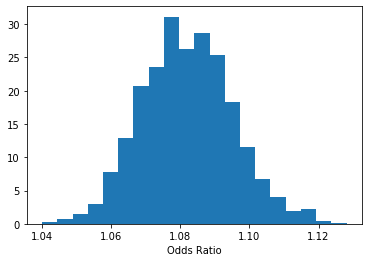

In [22]:
b = trace['education']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show();

In [23]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(1.058 < Odds Ratio < 1.109) = 0.95


We can interpret something along those lines: "With probability 0.95 the odds ratio is greater than 1.055 and less than 1.108, so the education effect takes place because a person with a higher education level has at least 1.055  higher probability to subscribe to a term deposit than a person with a lower education level, while holding all the other variables constant."

Compute odds ratio and percentage effect for all the variables.

In [24]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,odds_ratio,percentage_effect
Intercept,1.294854,0.239723,0.007872,0.836391,1.777836,804.211973,1.000031,3.650462,265.046232
age,-1.010070,0.088717,0.002851,-1.178565,-0.832153,793.165859,1.003852,0.364194,-63.580635
age2,0.118898,0.009479,0.000303,0.100233,0.136978,810.530702,1.002977,1.126255,12.625465
job,0.000183,0.007517,0.000179,-0.013276,0.015327,1815.862536,1.000178,1.000183,0.018295
marital,-0.023051,0.029425,0.000586,-0.078913,0.035141,1867.474513,1.000814,0.977213,-2.278717
education,0.078765,0.012193,0.000288,0.055340,0.102337,1628.603794,1.003416,1.081950,8.194952
default,-0.222486,0.032760,0.000698,-0.289351,-0.161967,2098.688035,0.999948,0.800526,-19.947418
housing,-0.010428,0.037834,0.000899,-0.088980,0.060693,1982.930627,1.001296,0.989626,-1.037424
loan,-0.058066,0.044953,0.001070,-0.135537,0.039939,1833.596227,0.999811,0.943588,-5.641222
contact,-0.136948,0.054112,0.001223,-0.245408,-0.032852,1745.059467,0.999672,0.872016,-12.798415


with a one unit increase in education, the odds of subscribing to a term deposit increases by 8%. Similarly, for a one unit increase in euribor3m, the odds of subscribing to a term deposit decreases by 43%. holding all other independent variables constant.

## Credible Interval

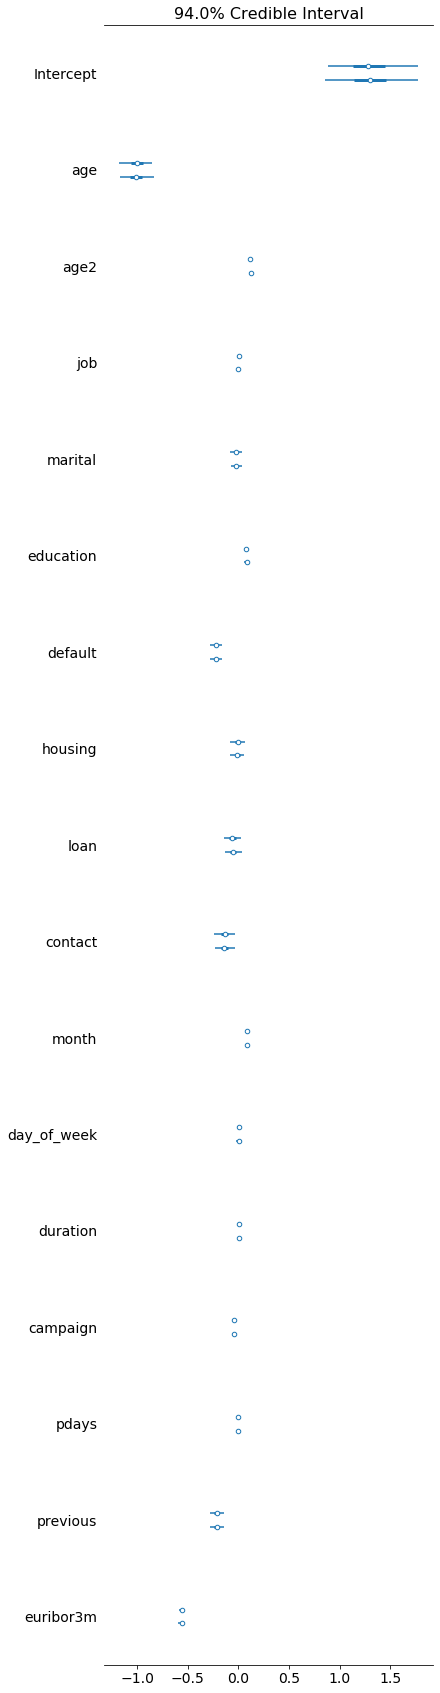

In [25]:
az.plot_forest(trace);

There's a baseline probability of subscribing a term deposit. Beyond that, age has the biggest effect on subscribing.

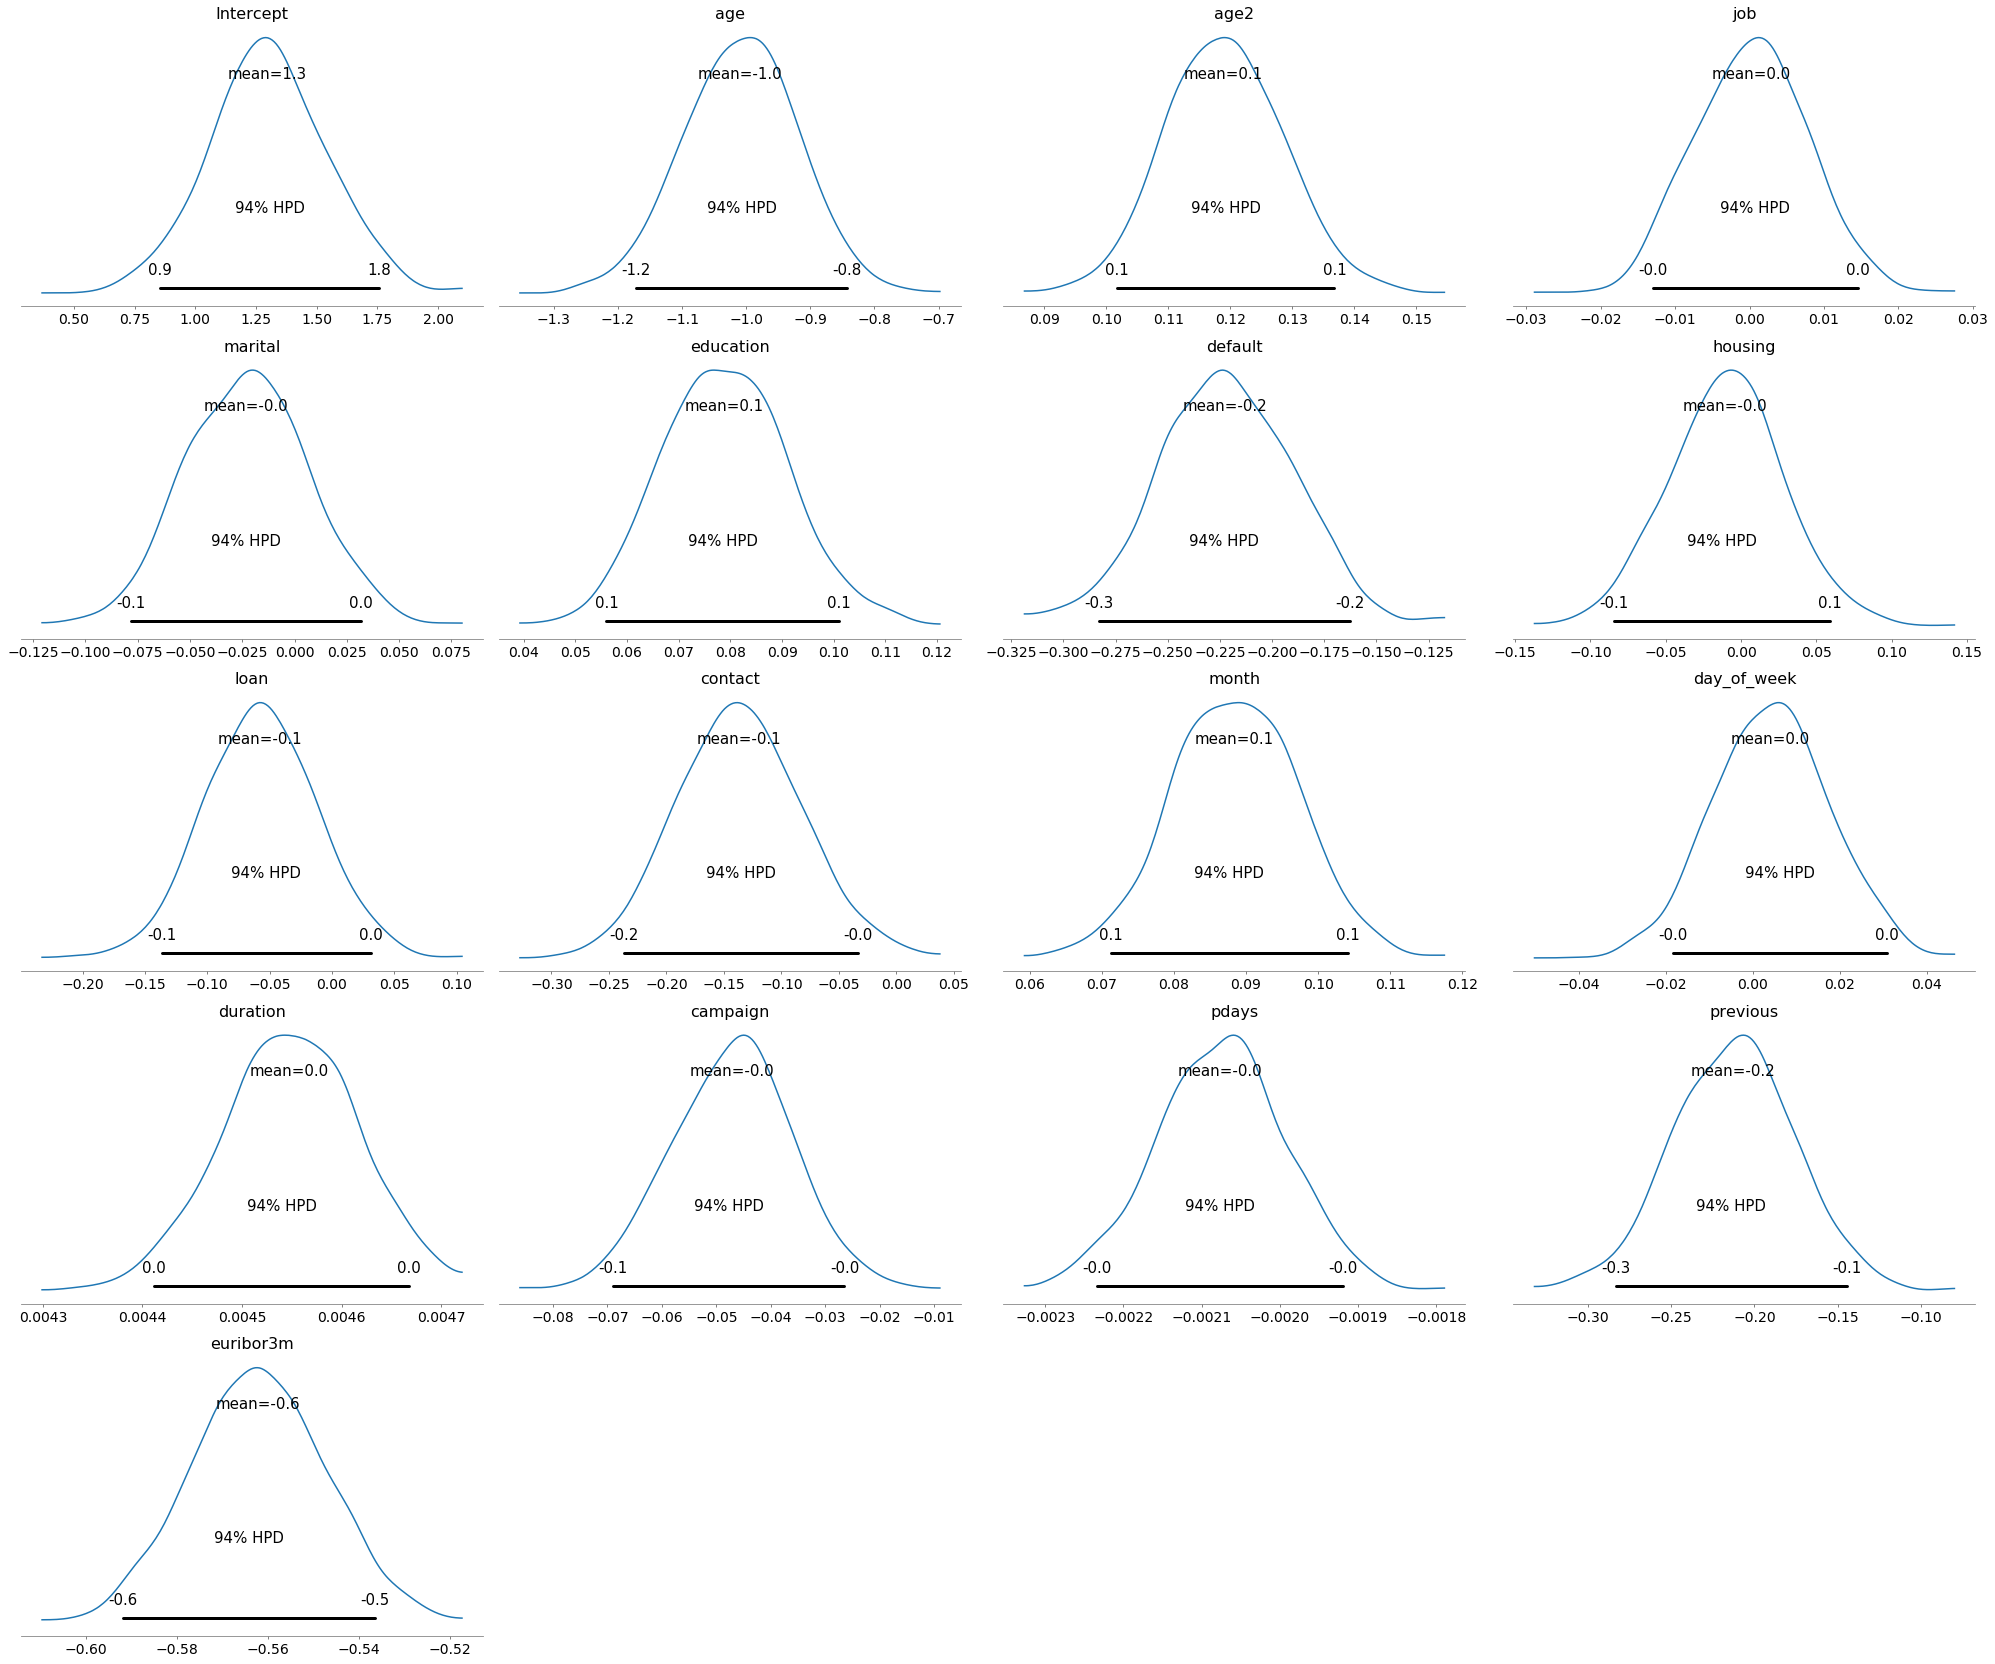

In [26]:
pm.plot_posterior(trace);

## Compare models using Widely-applicable Information Criterion (WAIC)

In [28]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('outcome ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

models_lin, traces_lin = run_models(data, 3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:43<00:00,  4.93draws/s] 
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [25:02<00:00,  3.76draws/s] 
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [np.power(age, 3), np.power(age, 2), euribor3m, previous, pdays, campaign, duration, day_of_week, month, contact, loan, housing, default, education, marital, job, age, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [1:32:48<00:00,  1.39s/draws]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


       WAIC  pWAIC   dWAIC weight      SE    dSE var_warn
k3    18273  20.28       0   0.91   227.6      0        0
k2  18302.9  19.45   29.83   0.04  227.66  12.12        0
k1  18448.7  17.87  175.66   0.05  228.27   28.4        0


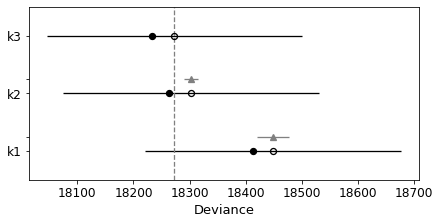

In [29]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic='WAIC')
print(dfwaic)
pm.compareplot(dfwaic);

In [30]:
dfwaic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k3,18273,20.28,0,0.91,227.6,0,0
k2,18302.9,19.45,29.83,0.04,227.66,12.12,0
k1,18448.7,17.87,175.66,0.05,228.27,28.4,0


## Posterior predictive check

We are going to calculate the metrics using the mean value of the parameters as a "most likely" estimate.

In [31]:
ppc = pm.sample_ppc(trace, model=logistic_model, samples=500)

100%|██████████| 500/500 [00:02<00:00, 191.77it/s]


In [32]:
ppc['y'].mean(axis=0)

array([0.006, 0.028, 0.742, ..., 0.006, 0.172, 0.02 ])

In [33]:
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

In [34]:
def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

Confusion matrix
[[35648   900]
 [ 2867  1773]]


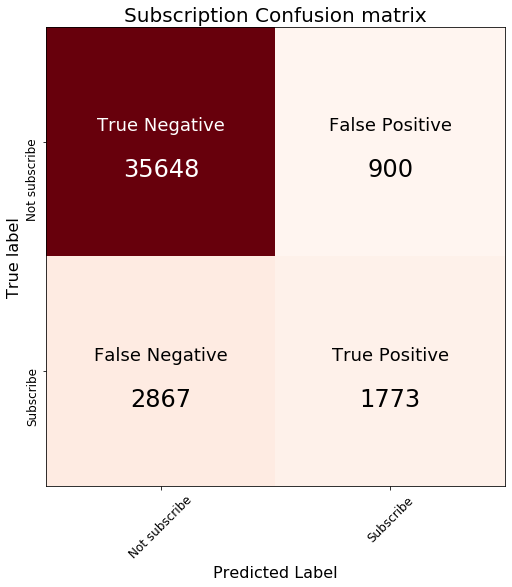

In [35]:
cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [36]:
print('Accuracy of the full model: ', accuracy_score(preds, data['outcome']))
print('f1 score of the full model: ', f1_score(preds, data['outcome']))

Accuracy of the full model:  0.908541322715354
f1 score of the full model:  0.4848899220566115
